In [2]:
import pandas as pd
import python_files.names as n
import python_files.functions as functions
import seaborn as sns
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from python_files import pipelines
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import pickle


from sklearn.model_selection import train_test_split

In [3]:
X = functions.prepare_transactions_dataset(path_to_dataset='../train_data/', num_parts_total=1)
y = pd.read_csv('../train_data/train_target.csv')

print(X.shape, y.shape)

X.head(3)

Transforming transactions data:   0%|          | 0/1 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

(1974724, 61) (3000000, 2)


,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,1,18,9,2,3,16,10,11,3,...,3,3,3,4,1,3,4,1,0,0
1,0,2,18,9,14,14,12,12,0,3,...,0,0,0,4,1,3,4,1,0,0
2,0,3,18,9,4,8,1,11,11,0,...,0,0,0,4,1,2,3,1,1,1


In [4]:
categorical_cols = ([#n.c.ID
                     #n.c.RN,
                     n.c.PRE_SINCE_OPENED,
                     n.c.PRE_SINCE_CONFIRMED,
                     n.c.PRE_PTERM,
                     n.c.PRE_FTERM,
                     n.c.PRE_TILL_PCLOSE,
                     n.c.PRE_TILL_FCLOSE,
                     n.c.PRE_LOANS_CREDIT_LIMIT,
                     n.c.PRE_LOANS_NEXT_PAY_SUMM,
                     n.c.PRE_LOANS_OUTSTANDING,
                     #n.c.PRE_LOANS_TOTAL_OVERDUE, It doest have valued values
                     n.c.PRE_LOANS_MAX_OVERDUE_SUM,
                     n.c.PRE_LOANS_CREDIT_COST_RATE,
                     
                     n.c.PRE_LOANS5,
                     n.c.PRE_LOANS530,
                     n.c.PRE_LOANS3060,
                     #n.c.PRE_LOANS6090, Same
                     #n.c.PRE_LOANS90, Same
                    
                     n.c.PRE_UTIL,
                     n.c.PRE_OVER2LIMIT,
                     n.c.PRE_MAXOVER2LIMIT,
                    ]

                     +  [f'enc_paym_{i}' for i in range(25)]  +

                     [
                        n.c.ENC_LOANS_ACCOUNT_HOLDER_TYPE, 
                        n.c.ENC_LOANS_CREDIT_STATUS, 
                        #n.c.ENC_LOANS_ACCOUNT_CUR, I don't know why we need currency
                        n.c.ENC_LOANS_CREDIT_TYPE
                    ]
)

In [5]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)#, max_categories=30
cols_for_ohe = categorical_cols
ohe_cols_out = []

main_pl = Pipeline([
    ('ohe', pipelines.OheColumns(ohe, cols_for_ohe, ohe_cols_out)),
    ('group_by', pipelines.GroupAndGetterSum(n.c.ID, ohe_cols_out)),
    ('merger', pipelines.MergerWithY(n.c.ID, n.c.FLAG)),
    ('leave_columns', pipelines.LeaverColumns([ohe_cols_out])),
])

X = main_pl.fit_transform(X, y)
y = y.iloc[X.index, 1]

In [6]:
X_ = X.sample(80000)
y_ = y[X_.index]

X_train, X_check, y_train, y_check = train_test_split(X_, y_, test_size=0.25, random_state=42)

In [7]:
cleaner_outliers_pl = Pipeline(
    [
        ('_', pipelines.CleanerOutliersWithIsolationForest(IsolationForest(contamination=0.05, random_state=42))),
    ]
)

X_train = cleaner_outliers_pl.fit_transform(X_train)
y_train = y_train[X_train.index]

In [8]:
model_pl = Pipeline([
    #('preprocessor') I don't have it
    ('model', CatBoostClassifier()),
])

model_pl.fit(X_train, y_train)

Learning rate set to 0.057902
0:	learn: 0.6017587	total: 196ms	remaining: 3m 15s
1:	learn: 0.5270510	total: 224ms	remaining: 1m 51s
2:	learn: 0.4645450	total: 243ms	remaining: 1m 20s
3:	learn: 0.4121819	total: 270ms	remaining: 1m 7s
4:	learn: 0.3684692	total: 299ms	remaining: 59.5s
5:	learn: 0.3321297	total: 325ms	remaining: 53.9s
6:	learn: 0.3015217	total: 346ms	remaining: 49.1s
7:	learn: 0.2760364	total: 371ms	remaining: 46.1s
8:	learn: 0.2546386	total: 395ms	remaining: 43.5s
9:	learn: 0.2366287	total: 422ms	remaining: 41.8s
10:	learn: 0.2217129	total: 443ms	remaining: 39.8s
11:	learn: 0.2087699	total: 474ms	remaining: 39s
12:	learn: 0.1981758	total: 495ms	remaining: 37.6s
13:	learn: 0.1891155	total: 522ms	remaining: 36.8s
14:	learn: 0.1810097	total: 564ms	remaining: 37s
15:	learn: 0.1744054	total: 584ms	remaining: 35.9s
16:	learn: 0.1686809	total: 617ms	remaining: 35.7s
17:	learn: 0.1638380	total: 647ms	remaining: 35.3s
18:	learn: 0.1597966	total: 683ms	remaining: 35.3s
19:	learn: 0

Pipeline(steps=[('model',
                 <catboost.core.CatBoostClassifier object at 0x00000209B78FA130>)])

In [9]:
# Saving
with open('model.pkl', 'wb') as file:
    pickle.dump(model_pl, file)

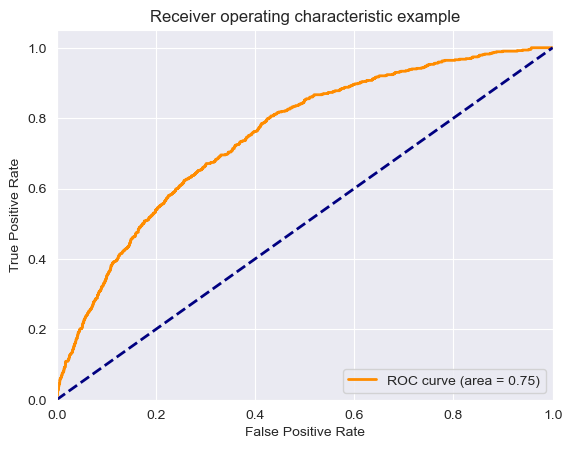

In [10]:
# Loading and prediction
with open('model.pkl', 'rb') as file:
    model = pickle.load(file)

model.predict_proba(X_check)
functions.visualize_roc_aug(y_check, model_pl.predict_proba(X_check)[:, 1])